In [89]:
# CUDA VERSION IS 10.1, so install cupy version matching cuda

GPU  = False
test = False

if GPU:
    import cupy as np
else: 
    import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
# PCA
from sklearn.decomposition import PCA, KernelPCA

In [90]:
def RMSD(x, y, axis=-1):
    """ Returns the mean squared error between 2 points,
        a set of points and a point, or 2 frames.
    """
    return np.sqrt(np.mean(np.linalg.norm(x-y, axis=axis)**2, axis=axis))


def similarity(tensor):
    """ Converts a matrix of distances between frames
        to a matrix of similarities between them.
    """
    return (tensor.max() - tensor) / tensor.max()


def kernel_v(tensor, axis=-1):
    """ Runs the kernel operation, but it's fully vectorized (ideal for parallelization).
        Worse for personal computers. Better for gpus and cpu clusters
    """
    return np.sqrt(np.mean(np.linalg.norm(tensor[:, np.newaxis, :, :] \
                                          - tensor, axis=-1)**2, axis=-1))


def kernel_filter(tensor, kernel=RMSD, axis=-1):
    """ Returns the filtered tensor after kernel application. """
    return np.array([kernel(tensor, frame_1, axis=axis) for frame_1 in tensor], dtype="float64")

In [91]:
data = "data/"
healthy_file, mutant_file = "data_healthy_ca.npy", "data_mutant_ca.npy"
healthy, mutant = np.load(data+healthy_file), np.load(data+mutant_file)

In [93]:
# run the kernel filter and convert to similarity matrix
kernel_func = kernel_filter

h = similarity(kernel_func(healthy, axis=-1))
m = similarity(kernel_func(mutant , axis=-1))

if GPU:
    h = np.asnumpy(h)
    m = np.asnumpy(m)

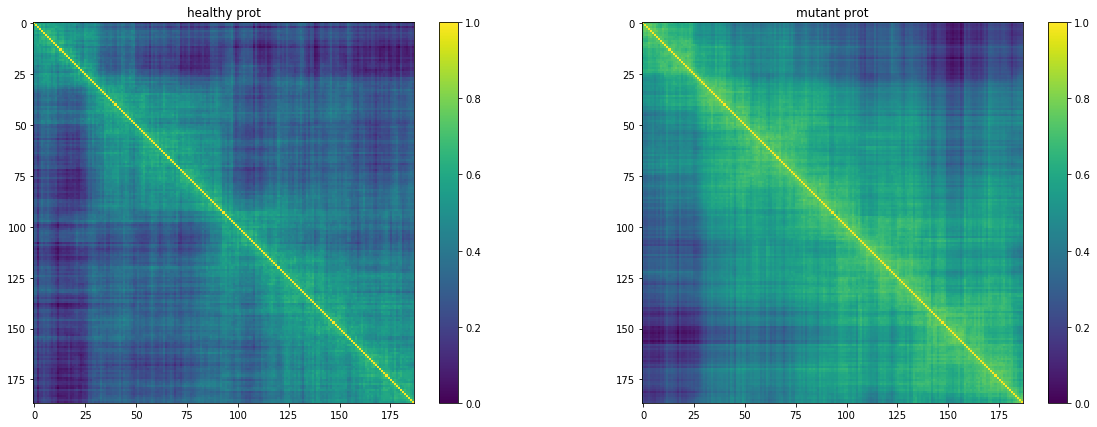

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# healthy prot
axs[0].set_title("healthy prot")
im0 = axs[0].imshow(h, cmap="viridis")
# mutated prot
axs[1].set_title("mutant prot")
im1 = axs[1].imshow(m, cmap="viridis")

fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])

plt.show()

In [95]:
pca = PCA(n_components=10)# KernelPCA(n_components=3, kernel="precomputed")
# fit with normal and project mutant
healthy_pca = pca.fit_transform(h)
mutant_pca  = pca.transform(m)

In [96]:
print("Percentage of variance explained by each component:", pca.explained_variance_ratio_[:5]*100)
print("Percentage of variance explained by first 4       :", pca.explained_variance_ratio_[:4].sum())

Percentage of variance explained by each component: [52.3209473  24.88482291  8.75813916  4.97398936  1.2976818 ]
Percentage of variance explained by first 4       : 0.909378987321439


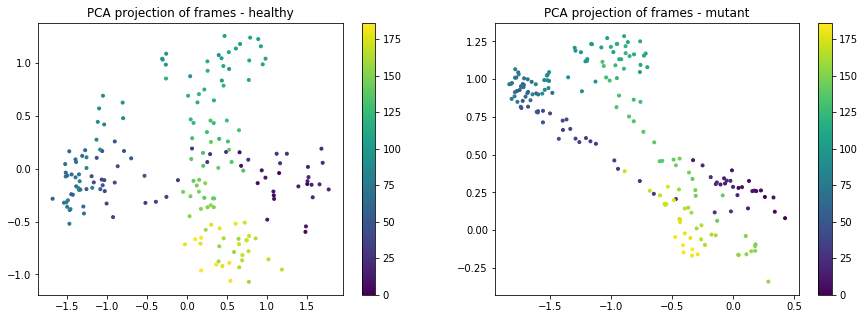

In [97]:
colors   = np.arange(0, healthy_pca.shape[0], 1)
if GPU:
    colors = np.asnumpy(colors)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# healthy prot
axs[0].set_title("PCA projection of frames - healthy")
points0 = axs[0].scatter(healthy_pca[:, 0+1], healthy_pca[:, 1+1], c=colors, marker=".")
# mutated prot
axs[1].set_title("PCA projection of frames - mutant")
points1 = axs[1].scatter(mutant_pca[:, 0+1], mutant_pca[:, 1+1], c=colors, marker=".")

fig.colorbar(points0, ax=axs[0])
fig.colorbar(points1, ax=axs[1])

plt.show()

# PLOTTING 2nd & 3rd COMPONENTS

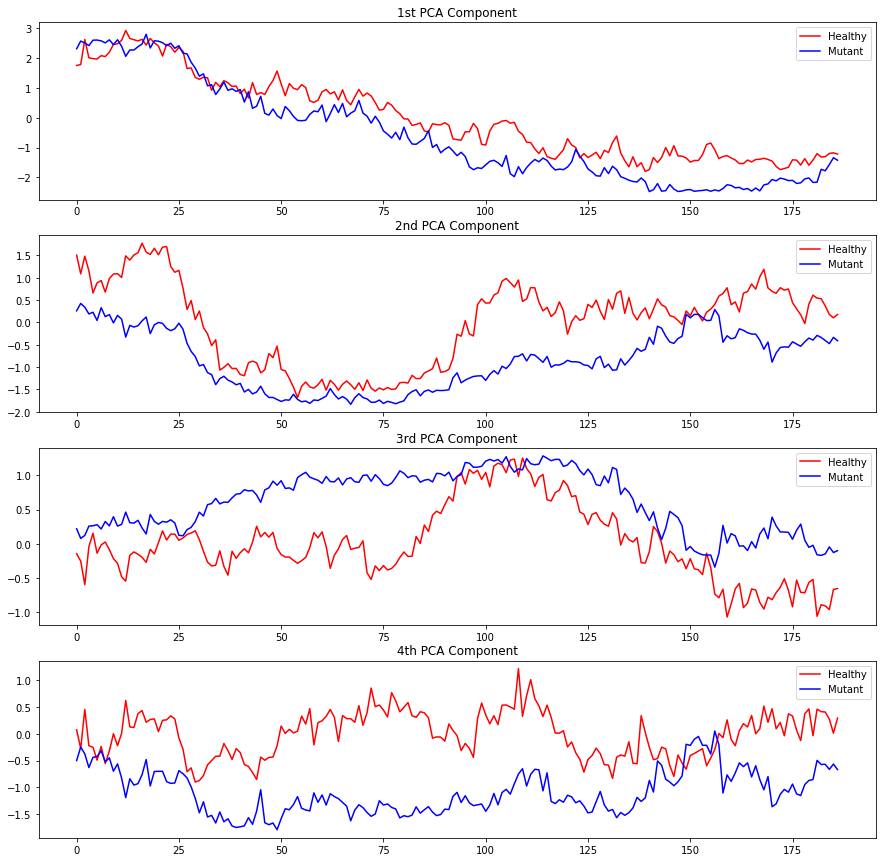

In [98]:
# PLOTS TO VISUALIZE THE DIFFERENCE:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))

# PCA Analysis
axs[0].set_title("1st PCA Component")
axs[0].plot(healthy_pca[:, 0], "r-")
axs[0].plot(mutant_pca[:, 0], "b-")
axs[0].legend(["Healthy", "Mutant"], loc="upper right")

axs[1].set_title("2nd PCA Component")
axs[1].plot(healthy_pca[:, 1], "r-")
axs[1].plot(mutant_pca[:, 1], "b-")
axs[1].legend(["Healthy", "Mutant"], loc="upper right")

axs[2].set_title("3rd PCA Component")
axs[2].plot(healthy_pca[:, 2], "r-")
axs[2].plot(mutant_pca[:, 2], "b-")
axs[2].legend(["Healthy", "Mutant"], loc="upper right")

axs[3].set_title("4th PCA Component")
axs[3].plot(healthy_pca[:, 3], "r-")
axs[3].plot(mutant_pca[:, 3], "b-")
axs[3].legend(["Healthy", "Mutant"], loc="upper right")

plt.show()

In [ ]:
# TESTING

In [92]:
if test:
    import timeit

    def test()  : return similarity(kernel_filter(healthy, axis=-1))
    def test_v(): return similarity(kernel_v(healthy, axis=-1))

    print("Without vectorization: ", timeit.timeit(test  , number=10))

    # w/ cupy, it can reach 10^-3 secs to process a 187-frame simulation
    # tracking 84 residues: https://colab.research.google.com/drive/1OwpwtRl9LY89gYKWCpBoLfyrcRDkwIdG
    print("With    vectorization: ", timeit.timeit(test_v, number=10))

Without vectorization:  0.48886146800032293
With    vectorization:  0.7272127809992526
